In [1]:
#Import statements
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal

In [2]:
#Load data 
import intake
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces = cat["ECCOv4r3"].to_dask()

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
_facet_strides = ((0,3), (3,6), (6,7), (7,10), (10,13))
# whether to reshape each face
_facet_reshape = (False, False, False, True, True)
_nfaces = 13
_nfacets = 5

import dask.array as dsa

def _uncompressed_facet_index(nfacet, nside):
    face_size = nside**2
    start = _facet_strides[nfacet][0] * face_size
    end = _facet_strides[nfacet][1] * face_size
    return start, end

def _facet_shape(nfacet, nside):
    facet_length = _facet_strides[nfacet][1] - _facet_strides[nfacet][0]
    if _facet_reshape[nfacet]:
        facet_shape = (1, 1, nside, facet_length*nside)
    else:
        facet_shape = (1, 1, facet_length*nside, nside)
    return facet_shape

def _facet_to_faces(data, nfacet):
    nz, nf, ny, nx = data.shape
    assert nf == 1
    facet_length = _facet_strides[nfacet][1] - _facet_strides[nfacet][0]
    if _facet_reshape[nfacet]:
        new_shape = nz, ny, facet_length, nx / facet_length
        data_rs = data.reshape(new_shape)
        data_rs = np.moveaxis(data_rs, 2, 1) # dask-safe
    else:
        new_shape = nz, facet_length, ny / facet_length, nx
        data_rs = data.reshape(new_shape)
    return data_rs

def _faces_to_facets(data, facedim=-3):
    assert data.shape[facedim] == _nfaces
    facets = []
    for nfacet, (strides, reshape) in enumerate(zip(_facet_strides, _facet_reshape)):
        face_data = [data[(...,) + (slice(nface, nface+1), slice(None), slice(None))]
                     for nface in range(*strides)]
        if reshape:
            concat_axis = facedim + 2
        else:
            concat_axis = facedim + 1
        # todo: use duck typing for concat
        facet_data = dsa.concatenate(face_data, axis=concat_axis)
        facets.append(facet_data)
    return facets


def _rotate_scalar_facet(facet):
    #facet_transposed = facet.transpose(0, 1, 3, 2)
    facet_transposed = np.moveaxis(facet, -1, -2)
    facet_rotated = np.flip(facet_transposed, -2)
    return facet_rotated


def _facets_to_latlon_scalar(all_facets):
    rotated = (all_facets[:2]
               + [_rotate_scalar_facet(facet) for facet in all_facets[-2:]])
    # drop facet dimension
    rotated = [r[..., 0, :, :] for r in rotated]
    return dsa.concatenate(rotated, axis=-1)


def _faces_to_latlon_scalar(data):
    data_facets = _faces_to_facets(data)
    return _facets_to_latlon_scalar(data_facets)

# dask's pad function doesn't work
# it does weird things to non-pad dimensions
# need to roll our own
def shift_and_pad(a):
    a_shifted = a[..., 1:]
    pad_array = dsa.zeros_like(a[..., -2:-1])
    return dsa.concatenate([a_shifted, pad_array], axis=-1)

def transform_v_to_u(facet):
    return _rotate_scalar_facet(facet)

def transform_u_to_v(facet, metric=False):
    # "shift" u component by 1 pixel
    pad_width = (facet.ndim - 1) * (None,) + ((1, 0),)
    #facet_padded = dsa.pad(facet[..., 1:], pad_width, 'constant')
    facet_padded = shift_and_pad(facet)
    assert facet.shape == facet_padded.shape
    facet_rotated = _rotate_scalar_facet(facet_padded)
    if not metric:
        facet_rotated = -facet_rotated
    return facet_rotated

def _facets_to_latlon_vector(facets_u, facets_v, metric=False):
    # need to pad the rotated v values
    ndim = facets_u[0].ndim
    # second-to-last axis is the one to pad, plus a facet axis
    assert ndim >= 3

    # drop facet dimension
    facets_u_drop = [f[..., 0, :, :] for f in facets_u]
    facets_v_drop = [f[..., 0, :, :] for f in facets_v]

    u_rot = (facets_u_drop[:2]
             + [transform_v_to_u(facet) for facet in facets_v_drop[-2:]])
    v_rot = (facets_v_drop[:2]
             + [transform_u_to_v(facet) for facet in facets_u_drop[-2:]])

    u = dsa.concatenate(u_rot, axis=-1)
    v = dsa.concatenate(v_rot, axis=-1)
    return u, v

def _faces_to_latlon_vector(u_faces, v_faces, metric=False):
    u_facets = _faces_to_facets(u_faces)
    v_facets = _faces_to_facets(v_faces)
    u, v = _facets_to_latlon_vector(u_facets, v_facets, metric=metric)
    return u, v

def _drop_facedim(dims):
    dims = list(dims)
    dims.remove('face')
    return dims
def faces_dataset_to_latlon(ds, metric_vector_pairs=[('dxC', 'dyC'), ('dyG', 'dxG')]):
    coord_vars = list(ds.coords)
    coords = ds.reset_coords().coords.to_dataset()
    ifac = 4
    jfac = 3
    dim_coords = {}
    for vname in coords.coords:
        if vname[0] == 'i':
            data = np.arange(ifac * coords.dims[vname])
        elif vname[0] == 'j':
            data = np.arange(jfac * coords.dims[vname])
        else:
            data = coords[vname].data
        var = xr.Variable(ds[vname].dims, data, ds[vname].attrs)
        dim_coords[vname] = var
    ds_new = xr.Dataset(dim_coords)
    
    vector_pairs = []
    scalars = []
    vnames = list(ds.reset_coords().variables)
    for vname in vnames:
        try:
            mate = ds[vname].attrs['mate']
            vector_pairs.append((vname, mate))
            vnames.remove(mate)
        except KeyError:
            pass
        
            
    all_vector_components = [inner for outer in (vector_pairs + metric_vector_pairs)
                             for inner in outer]
    scalars = [vname for vname in vnames if vname not in all_vector_components]
    data_vars = {}
    
    for vname in scalars:
        if vname=='face' or vname in ds_new:
            continue
        if 'face' in ds[vname].dims: 
            data = _faces_to_latlon_scalar(ds[vname].data)
            dims = _drop_facedim(ds[vname].dims)
        else:
            data = ds[vname].data    
            dims = ds[vname].dims
        data_vars[vname] = xr.Variable(dims, data, ds[vname].attrs)
        
    for vname_u, vname_v in vector_pairs:
        data_u, data_v = _faces_to_latlon_vector(ds[vname_u].data, ds[vname_v].data)
        data_vars[vname_u] = xr.Variable(_drop_facedim(ds[vname_u].dims), data_u, ds[vname_u].attrs)
        data_vars[vname_v] = xr.Variable(_drop_facedim(ds[vname_v].dims), data_v, ds[vname_v].attrs)
    for vname_u, vname_v in metric_vector_pairs:
        data_u, data_v = _faces_to_latlon_vector(ds[vname_u].data, ds[vname_v].data, metric=True)
        data_vars[vname_u] = xr.Variable(_drop_facedim(ds[vname_u].dims), data_u, ds[vname_u].attrs)
        data_vars[vname_v] = xr.Variable(_drop_facedim(ds[vname_v].dims), data_v, ds[vname_v].attrs)
    

    ds_new = ds_new.update(data_vars)
    ds_new = ds_new.set_coords([c for c in coord_vars if c in ds_new])
    return ds_new


In [4]:
#Apply Ryan's code to the dataset
ds_ll = faces_dataset_to_latlon(ds_faces)

#Exclude 1992 and put the Atlantic in the middle 
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False)
      .loc[dict(time=slice('1993-01-15','2015-12-14'))]
     .loc[dict(time_snp=slice('1993-02-01','2015-12-01'))])#

#Make a corresponding dataset of the coordinates of ds, with the same conditions as above(?)
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False)
          .loc[dict(time=slice('1993-01-15','2015-12-14'))]
         .loc[dict(time_snp=slice('1993-02-01','2015-12-01'))])#

In [5]:
#What's the point of load here?
#Why does np.diff(ds.time_snp) return the huge values 
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]

# Rename time_snp coordinate to time coordaintes 
dt = dt.rename({'time_snp':'time'})

#set the dt axis to the same values as the ds month midpoints 
dt.time.values = ds.time[1:-1].values 

#make a new ds object with the dt coordinate 
ds = ds.assign_coords(dt=dt)

#set the attributes of the dt coordinate 
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}
ds.dt


<xarray.DataArray 'dt' (time: 276)>
array([     nan, 2419200., 2678400., ..., 2678400., 2592000.,      nan])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-15 1993-02-12 ... 2015-12-14
    dt       (time) float64 nan 2.419e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
Attributes:
    units:          s
    standard_name:  dt
    coordinate:     time
    long_name:      time span between snapshots

In [6]:
#Time integral
rho0=1029 
cp=3994

#2 faces on the surface for divergence theorem - this is just one face 

#ADVy_TH is the flux of advection
#sum_long sum_surface of advection per unit area -> total advection over latitude band 
mht1=(ds['ADVy_TH'][:,:,221,136:230]*rho0*cp).sum(['i','k']) 

#Finding the average advection - the total advection as a function of time is multiplied 
#by the change in time of that time-cell, summed and averaged to get a weighted time mean
meanmht1=(mht1*ds.dt).sum('time')/(ds.dt.sum('time')) 

#Remove mean, weigh it by ds.dt change in time factor, and take the integral (cumsum)
mhc1=((mht1-meanmht1)*ds.dt).cumsum('time')#.load()
mhc1

<xarray.DataArray (time: 276)>
dask.array<nancumsum, shape=(276,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    j_g      int64 221
  * time     (time) datetime64[ns] 1993-01-15 1993-02-12 ... 2015-12-14
    dt       (time) float64 nan 2.419e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

In [7]:
#2nd face 
mht2=(ds['ADVy_TH'][:,:,259,136:230]*rho0*cp).sum(['i','k'])
meanmht2=(mht2*ds.dt).sum('time')/(ds.dt.sum('time')) 
mhc2=((mht2-meanmht2)*ds.dt).cumsum('time')
mht2

<xarray.DataArray 'ADVy_TH' (time: 276)>
dask.array<sum-aggregate, shape=(276,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    j_g      int64 259
  * time     (time) datetime64[ns] 1993-01-15 1993-02-12 ... 2015-12-14
    dt       (time) float64 nan 2.419e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

(-1.2e+22, 1.2e+22)

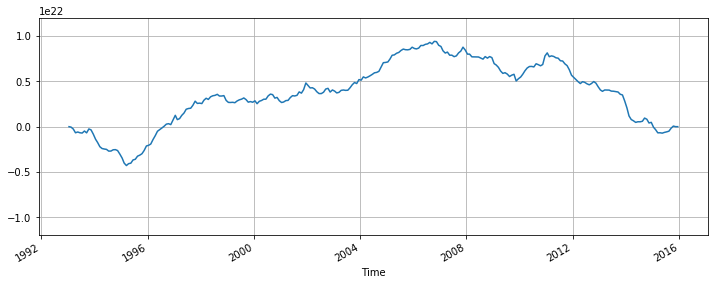

In [10]:
#net face
netAdv = mhc1-mhc2 
plt.figure(figsize=(12,4))
plt.grid()
netAdv.plot()
plt.ylim(-1.2*10**22,1.2*10**22)

In [24]:
#New Work 18 Nov 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
THETA_jg = grid.interp(ds.THETA, axis = 'Y')

In [27]:
coords.dx

<xarray.DataArray 'dxG' (j_g: 270, i: 360)>
dask.array<concatenate, shape=(270, 360), dtype=float32, chunksize=(89, 90), chunktype=numpy.ndarray>
Coordinates:
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
Attributes:
    coordinate:     YG XC
    long_name:      cell x size
    standard_name:  cell_x_size_at_v_location
    units:          m

In [34]:
#1st Face 
advy = ds.VVELMASS[:, :, 221, 136:220] * ds.THETA[:, :, 221, 136:220] * coords.drF * coords.dxG[221,136:220]
mht1_n =(advy[:,:,136:230]*rho0*cp).sum(['i','k'])
meanmht1_new=(mht1_n*ds.dt).sum('time')/(ds.dt.sum('time')) 
mhc1_new=((mht1_n-meanmht1_new)*ds.dt).cumsum('time')
mhc1_new

<xarray.DataArray (time: 276)>
dask.array<nancumsum, shape=(276,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1993-01-15 1993-02-12 ... 2015-12-14
    dt       (time) float64 nan 2.419e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan

In [38]:
#2nd Face
advy = ds.VVELMASS[:, :, 259, 136:220] * ds.THETA[:, :, 259, 136:220] * coords.drF * coords.dxG[259,136:220]
mht2_n =(advy[:,:,136:230]*rho0*cp).sum(['i','k'])
meanmht2_new=(mht2_n*ds.dt).sum('time')/(ds.dt.sum('time')) 
mhc2_new = ((mht2_n-meanmht2_new)*ds.dt).cumsum('time')
mhc2_new

<xarray.DataArray (time: 276)>
dask.array<nancumsum, shape=(276,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    j_g      int64 259
  * time     (time) datetime64[ns] 1993-01-15 1993-02-12 ... 2015-12-14
    dt       (time) float64 nan 2.419e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
    j        int64 259

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(-1.2e+22, 1.2e+22)

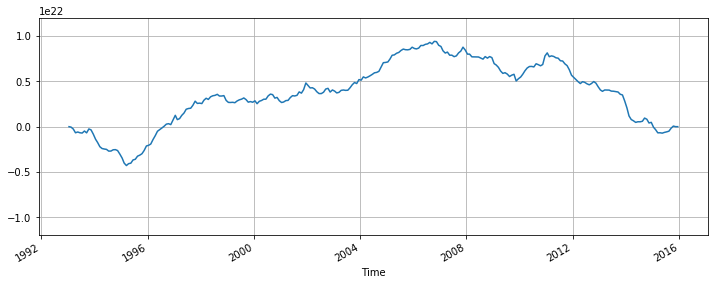

In [39]:
#Net Face
netAdv_new = mhc1_new-mhc2_new 
plt.figure(figsize=(12,4))
plt.grid()
netAdv.plot()
plt.ylim(-1.2*10**22,1.2*10**22)

In [45]:
ds.ADVy_TH

<xarray.DataArray 'ADVy_TH' (time: 276, k: 50, j_g: 270, i: 360)>
dask.array<getitem, shape=(276, 50, 270, 360), dtype=float32, chunksize=(1, 50, 89, 90), chunktype=numpy.ndarray>
Coordinates:
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 ... 262 263 264 265 266 267 268 269
  * time     (time) datetime64[ns] 1993-01-15 1993-02-12 ... 2015-12-14
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * i        (i) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
    dt       (time) float64 nan 2.419e+06 2.678e+06 ... 2.678e+06 2.592e+06 nan
Attributes:
    long_name:      Meridional Advective Flux of Pot.Temperature
    mate:           ADVx_TH
    standard_name:  ADVy_TH
    units:          degC.m^3/s